In [1]:
import cv2 
import imageio
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random
import scipy.ndimage as ndi
import seaborn as sns; sns.set()
import tensorflow as tf

# Problem:
This is a ***binary classification supervised learning problem*** where the data has labels. The main goal is to predict whether an image shows metastastic tissue or not. 

# Exploratory Data Analysis 

In [2]:
traindf=pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
traindf.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


## Check for Class Imbalance

In [3]:
# sanity check that there are two classes 
traindf['label'].unique()

array([0, 1])

In [4]:
num_imgs = len(traindf)
print('Image number of training images:', num_imgs)

Image number of training images: 220025


In [5]:
# check to see if there is class imbalance 
labelCounts = traindf['label'].value_counts()
print(labelCounts)

0    130908
1     89117
Name: label, dtype: int64


In [6]:
# get the percentages 
traindf['label'].value_counts(normalize=True)

0    0.594969
1    0.405031
Name: label, dtype: float64

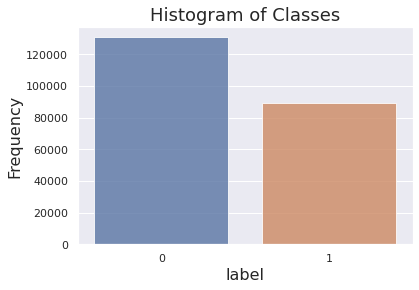

In [7]:
# histogram plotting function with KDE overlay 
# plot mean as a red line 
def hist_plot(x, df):
    count = df[x].value_counts()
    sns.barplot(count.index, count.values, alpha=0.8)
    plt.title("Histogram of Classes", fontsize=18)
    plt.xlabel(x, fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.show();

hist_plot("label", traindf)

There is about a 60% to 40% split of 0 labels to 1 labels. The **majority class** is no tumor tissue. 
This Google Developers' course indicates that if the minority class is 40% of the dataset that is a mild degree of imbalance. The recommendation for an imbalanced dataset is to first try training on the true distribution and see if the model works well and generalizes well. If it doesn't, techniques like downsampling or upweighting can be used. 
Source: https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data

## Show Sample Images with Labels 

In [8]:
def append_ext(fn):
    return fn+".tif"
""""
the id is the same as the filename without the .tif extension
add the .tif extension
this will make it possible to use datagen.flow_from_dataframe 
to create the datasets 
"""
traindf["id"]=traindf["id"].apply(append_ext)
traindf.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [9]:
# the training labels are the sample_submission.csv file 
testdf=pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv",dtype=str)
testdf["id"]=testdf["id"].apply(append_ext)
testdf.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif,0
1,95596b92e5066c5c52466c90b69ff089b39f2737.tif,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif,0
3,2c35657e312966e9294eac6841726ff3a748febf.tif,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif,0


In [10]:
data = plt.imread('/kaggle/input/histopathologic-cancer-detection/train/' + traindf["id"].iloc[0])
print('Shape of image array:', data.shape)

Shape of image array: (96, 96, 3)


The images are 96 x 96 pixels with 3 R,G, B color channels. 

In [11]:
# print image data type 
print('Image type:', data.dtype)

Image type: uint8


In [12]:
# display memory usage of image 
# in kilobytes 
print('Memory usage:', data.size, 'KB') 

Memory usage: 27648 KB


If all values in an image are positive, unsigned integers can cover the largest range of values while taking up the least amount of memory. 

## Image Metadata


In [13]:
# load dictionary of available metadata 
im = imageio.imread('/kaggle/input/histopathologic-cancer-detection/train/' + traindf["id"].iloc[0])
im.meta

Dict([('is_fluoview', False),
      ('is_nih', False),
      ('is_micromanager', False),
      ('is_ome', False),
      ('is_reduced', <FILETYPE.UNDEFINED: 0>),
      ('is_shaped', '{"shape": [96, 96, 3]}'),
      ('is_stk', False),
      ('is_tiled', False),
      ('compression', <COMPRESSION.NONE: 1>),
      ('predictor', 1),
      ('is_mediacy', False),
      ('description', '{"shape": [96, 96, 3]}'),
      ('description1', ''),
      ('is_imagej', None),
      ('software', 'tifffile.py'),
      ('datetime', datetime.datetime(2018, 11, 15, 17, 20, 32))])

Some image metadata contains information like patient demographics. In this case, the available metadata is limited to information like shape, datetime, and no compression. 

## Display random sampling of images with labels.

In [14]:
def random_sample(df, num_samples):
    """
    takes in dataframe 
    and number of samples 
    returns tuple with array of images,
    array of labels for those images
    """
    number_train_images = len(df)
    
    randomlist = random.sample(range(number_train_images), 
                               num_samples)
    imgs = []
    labels = []
    for i in randomlist:
        path = df.iloc[i]["id"]
        label = df.iloc[i]['label']
        imgs.append(path)
        labels.append(label)
    return (imgs, labels)

In [15]:
def display_image(imgs, labels, num_samples):
    """
    takes in arrays of images and labels
    displays image with label 
    """
    # Displaying the loaded images
    fig = plt.figure(figsize=(10, 4), dpi=150)

    for i in range(len(imgs)): 
        plt.axis('off')
        ax = fig.add_subplot(1, num_samples, i+1, xticks=[], yticks=[])
        data = plt.imread('/kaggle/input/histopathologic-cancer-detection/train/' + imgs[i])
        # imshow displays 2D image data 
        ax.imshow(data)
        ax.set_title('Label: ' + str(labels[i])) 

In [16]:
# filter out images with no tumor tissue
no_tumor_tissue = traindf[traindf['label']==0]
no_tumor_tissue.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7.tif,0


In [17]:
# filter out images with tumor tissue
tumor_tissue = traindf[traindf['label']==1]
tumor_tissue.head()

,id,label
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da.tif,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f.tif,1
11,c3d660212bf2a11c994e0eadff13770a9927b731.tif,1
14,94fa32b29cc1c00403176c0795fffa3cfaa0f20e.tif,1


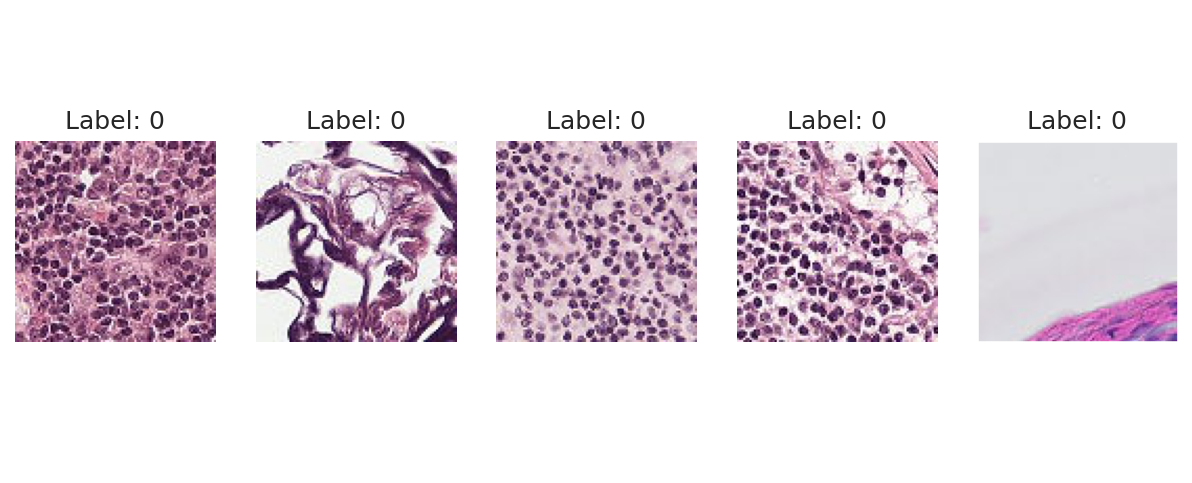

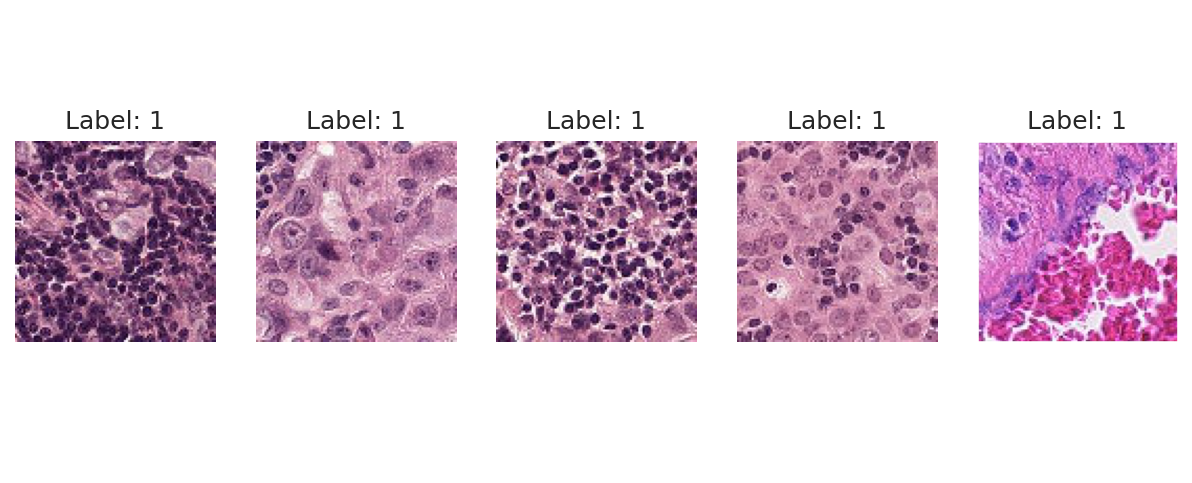

In [18]:
num_samples = 5 
# display negative images 
imgs_neg, labels_neg = random_sample(no_tumor_tissue, num_samples)
display_image(imgs_neg, labels_neg, num_samples)
# display positive images 
imgs_pos, labels_pos = random_sample(tumor_tissue, num_samples)
display_image(imgs_pos, labels_pos, num_samples)

As someone who isn't a professional pathologist, I can't identify the differences in classes from looking at these images alone.

## Image Intensity Histogram
**Pixels** are 2D picture elements. They have two properties: intensity and location. <br>
Histograms summarize the distribution of intensity values in an image. They bin each pixel by its value.

In [19]:
"""
this function is from this StackOverflow post:
https://stackoverflow.com/questions/55659784/plot-multiple-rgb-images-and-histogram-side-by-side-in-a-grid
"""
def histogram_img(img, title=None):
    plt.figure(figsize=(16,6))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)
    # cv2 is in B,G,R order
    colors = ('b','g','r')
    histograms = []

    for i in range(3): 
        hist = cv2.calcHist([img], [i], None, [256], [0, 255])
        histograms.append(hist)
        ax1.plot(hist, color=colors[i])
    ax2.imshow(img)
    ax2.grid(False)
    ax2.axis('off')    

    if title is not None:
        plt.title =  title

    plt.show()

In [20]:
def image_path(randomlist, df):
    img_path = []
    labels = []
    for i in randomlist:
        path = df.iloc[i]["id"]
        label = df.iloc[i]['label']
        image = cv2.imread('/kaggle/input/histopathologic-cancer-detection/train/' + path)
        img_path.append(image)
        labels.append(label)
    return (img_path, labels)

## Flattened Color Histograms: No Tumor Tissue 

In [21]:
#Generate random indices in the range of number of training images
randomlist = random.sample(range(len(no_tumor_tissue)), num_samples)
img_path, labels = image_path(randomlist, no_tumor_tissue)

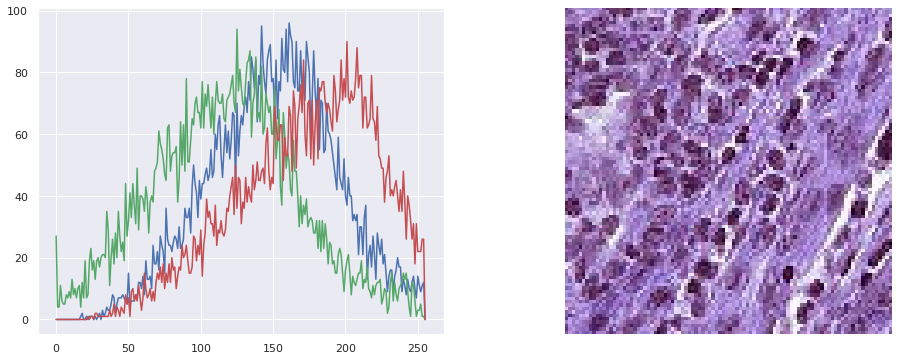

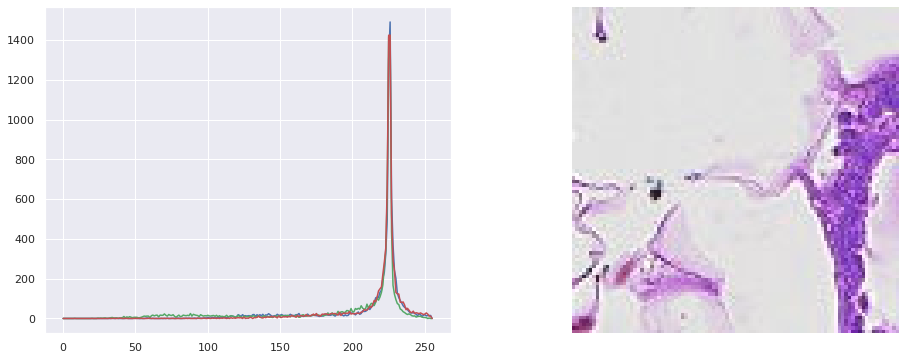

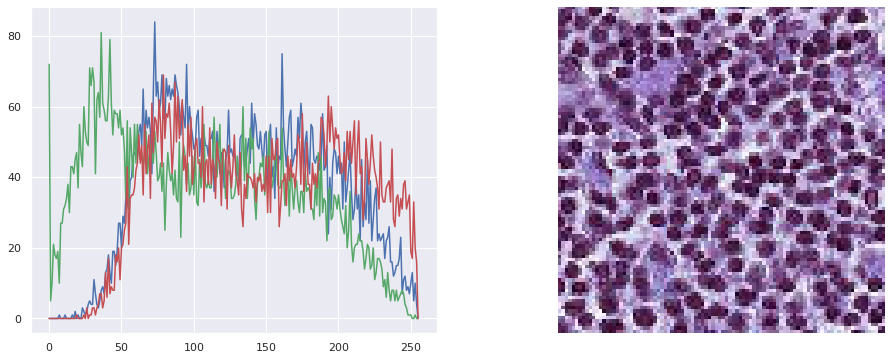

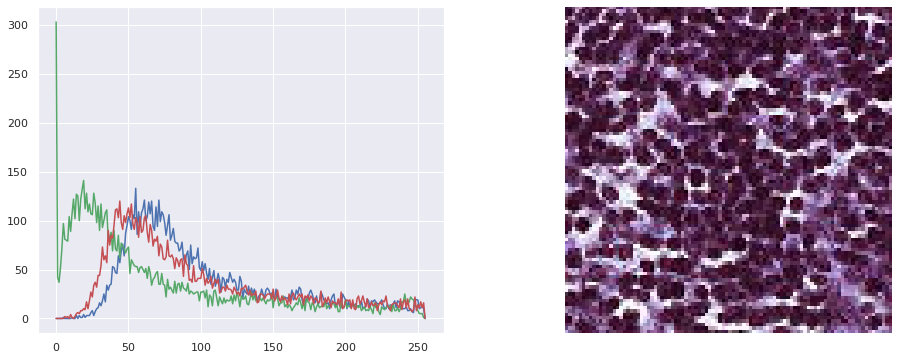

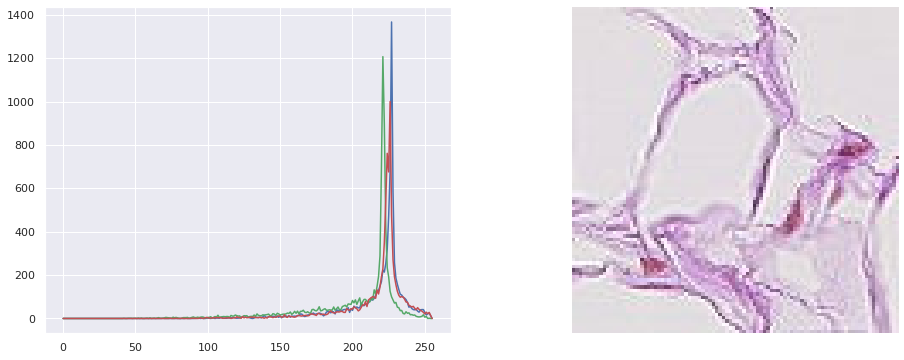

In [22]:
for i in range(len(img_path)):
    histogram_img(img_path[i])

## Flattened Color Histograms: Tumor Tissue

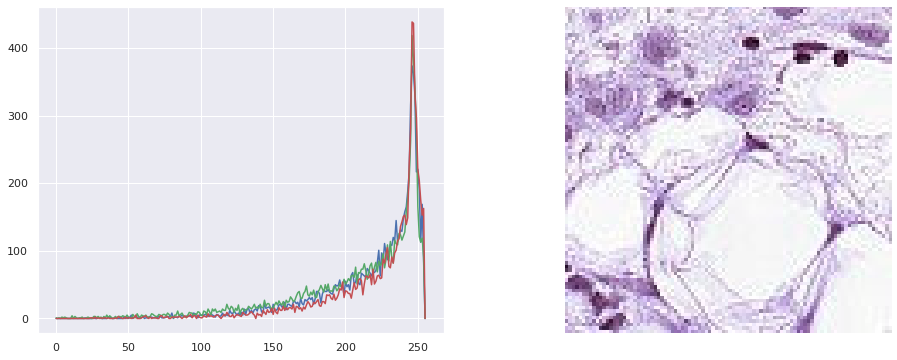

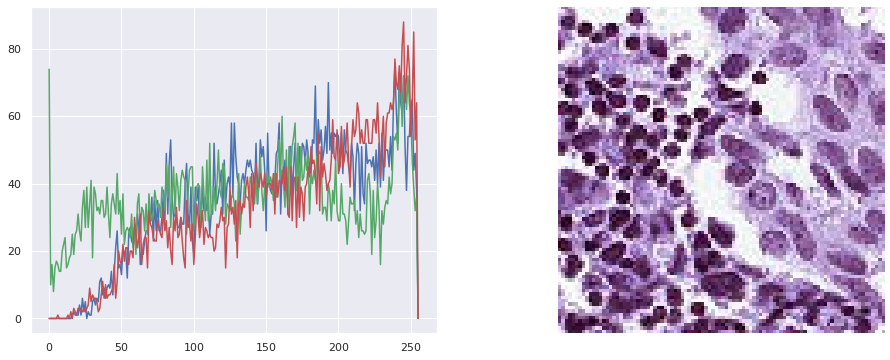

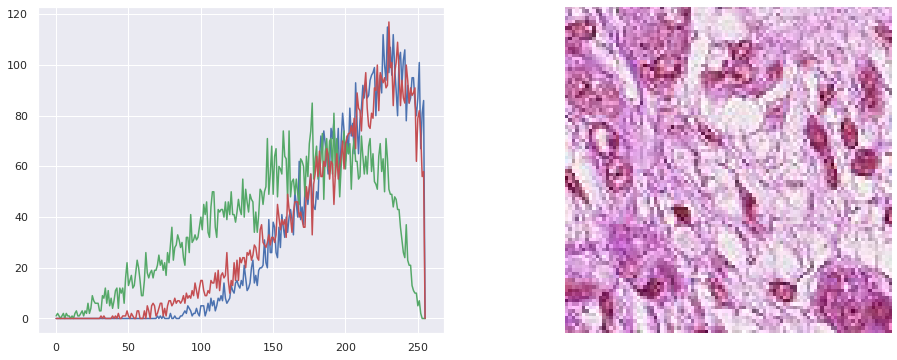

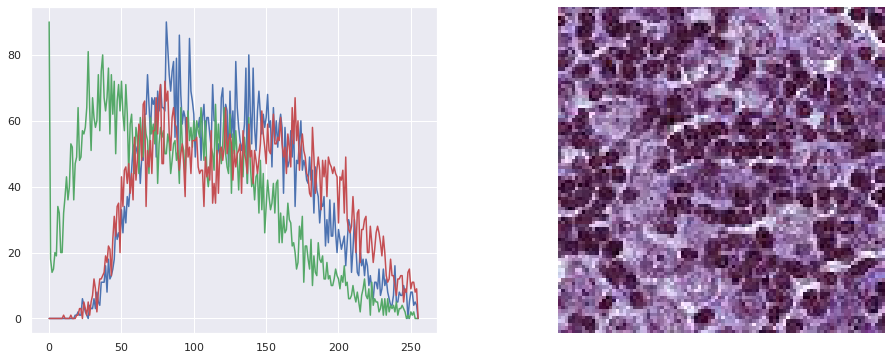

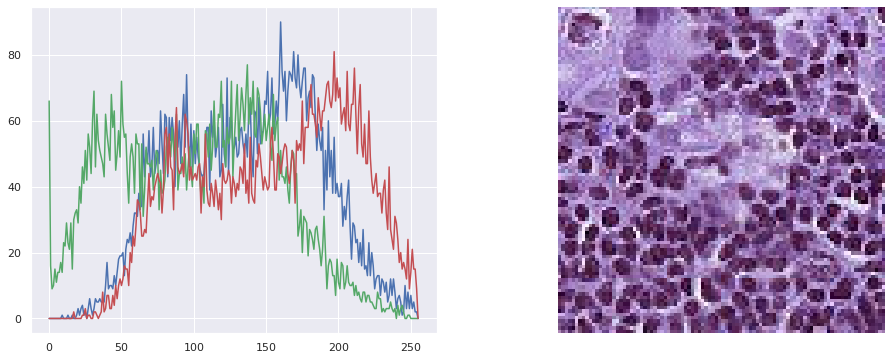

In [23]:
#Generate random indices in the range of number of training images
randomlist = random.sample(range(len(tumor_tissue)), num_samples)
img_path, labels = image_path(randomlist, tumor_tissue)

for i in range(len(img_path)):
    histogram_img(img_path[i])

Another resource consulted: 
+ https://www.pyimagesearch.com/2014/01/22/clever-girl-a-guide-to-utilizing-color-histograms-for-computer-vision-and-image-search-engines/